In [30]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor
import numpy as np

In [31]:
import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
building = pd.read_csv('data/building_info.csv')

In [32]:
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop(['num_date_time','sunshine','solar_radiation'], axis = 1, inplace=True)

In [33]:
test = test.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test.drop('num_date_time', axis = 1, inplace=True)

In [34]:
building = building.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

In [35]:
building.head()

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [36]:
translation_dict = {
    '건물기타': '1',
    '공공': '2',
    '대학교': '3',
    '데이터센터': '4',
    '백화점및아울렛': '3',
    '병원': '4',
    '상용': '5',
    '아파트': '6',
    '연구소': '7',
    '지식산업센터': '8',
    '할인마트': '9',
    '호텔및리조트': '10'
}

building['building_type'] = building['building_type'].replace(translation_dict)

## csv 병합

In [37]:
train = pd.merge(train, building, on='building_number', how='left')
test = pd.merge(test, building, on='building_number', how='left')

In [38]:
train.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,20220601 00,18.6,NaN,0.9,42.0,1085.28,1,110634.0,39570.0,-,-,-
1,1,20220601 01,18.0,NaN,1.1,45.0,1047.36,1,110634.0,39570.0,-,-,-
2,1,20220601 02,17.7,NaN,1.5,45.0,974.88,1,110634.0,39570.0,-,-,-
3,1,20220601 03,16.7,NaN,1.4,48.0,953.76,1,110634.0,39570.0,-,-,-
4,1,20220601 04,18.4,NaN,2.8,43.0,986.40,1,110634.0,39570.0,-,-,-


In [39]:
test.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,20220825 00,23.5,0.0,2.2,72,1,110634.0,39570.0,-,-,-
1,1,20220825 01,23.0,0.0,0.9,72,1,110634.0,39570.0,-,-,-
2,1,20220825 02,22.7,0.0,1.5,75,1,110634.0,39570.0,-,-,-
3,1,20220825 03,22.1,0.0,1.3,78,1,110634.0,39570.0,-,-,-
4,1,20220825 04,21.8,0.0,1.0,77,1,110634.0,39570.0,-,-,-


In [40]:
building.head()

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,1,110634.00,39570.00,-,-,-
1,2,1,122233.47,99000.00,-,-,-
2,3,1,171243.00,113950.00,40,-,-
3,4,1,74312.98,34419.62,60,-,-
4,5,1,205884.00,150000.00,-,2557,1000


## train전처리

In [41]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')

# date time feature 생성
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.weekday
train['month'] = train['date_time'].dt.month
#train['week'] = train['date_time'].dt.weekofyear

# 공휴일 변수 추가 
train['holiday'] = train['day'] .apply(lambda x : 0 if x<5 else 1)
train.loc[('2022-06-06'<=train.date_time)&(train.date_time<'2022-06-07'), 'holiday'] = 1
train.loc[('2022-08-15'<=train.date_time)&(train.date_time<'2022-08-16'), 'holiday'] = 1

# hour
train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)


def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101):
    temp = train[train['building_number'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

train['building_type'] = train['building_type'].apply(lambda x :int(x))

train = train.fillna(0)
train.drop(['date_time','hour','solar_power_capacity','ess_capacity','pcs_capacity'],axis = 1,inplace = True)


In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   building_number     204000 non-null  int64  
 1   temperature         204000 non-null  float64
 2   rainfall            204000 non-null  float64
 3   windspeed           204000 non-null  float64
 4   humidity            204000 non-null  float64
 5   power_consumption   204000 non-null  float64
 6   building_type       204000 non-null  int64  
 7   day                 204000 non-null  int32  
 8   month               204000 non-null  int32  
 9   holiday             204000 non-null  int64  
 10  sin_time            204000 non-null  float64
 11  cos_time            204000 non-null  float64
 12  CDH                 204000 non-null  float64
 13  cooling_area_ratio  204000 non-null  float64
dtypes: float64(9), int32(2), int64(3)
memory usage: 20.2 MB


In [43]:
## save the preprocessed data
train.to_csv('./data/train_preprocessed.csv')

## 모델링

In [44]:
## 7번 건물의 발전량으로 테스트
y = train.loc[train.building_number== 7, 'power_consumption']
x = train.loc[train.building_number == 7, ].drop(['power_consumption','building_number'], axis = 1)

In [45]:
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)

train data shape
x:(1872, 12), y:(1872,)


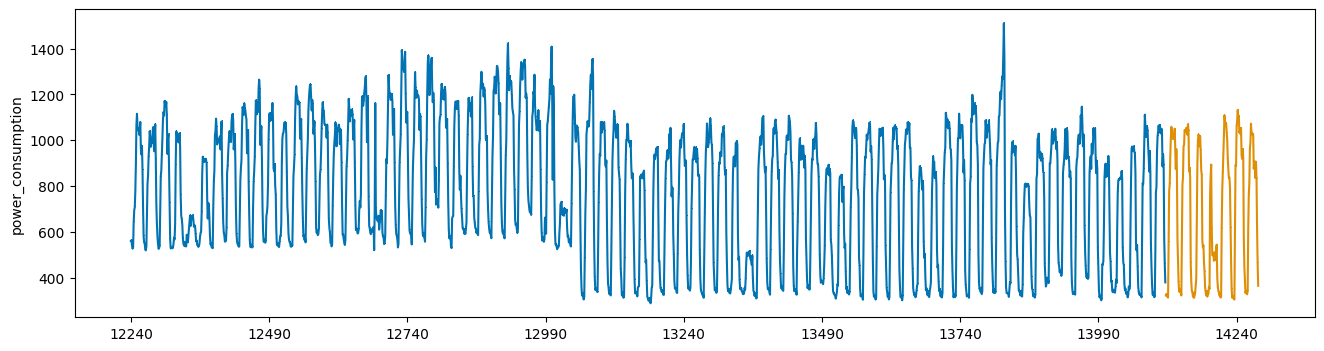

In [46]:
print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

In [47]:
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [48]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [49]:
xgb_reg = XGBRegressor(n_estimators = 10000, eta = 0.03, min_child_weight = 3, 
                       max_depth = 8, colsample_bytree = 0.9, 
                       subsample = 0.7, seed=0)

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

C:\Users\ARIZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eta=0.03, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

best iterations: 136
SMAPE : 4.129639066167893


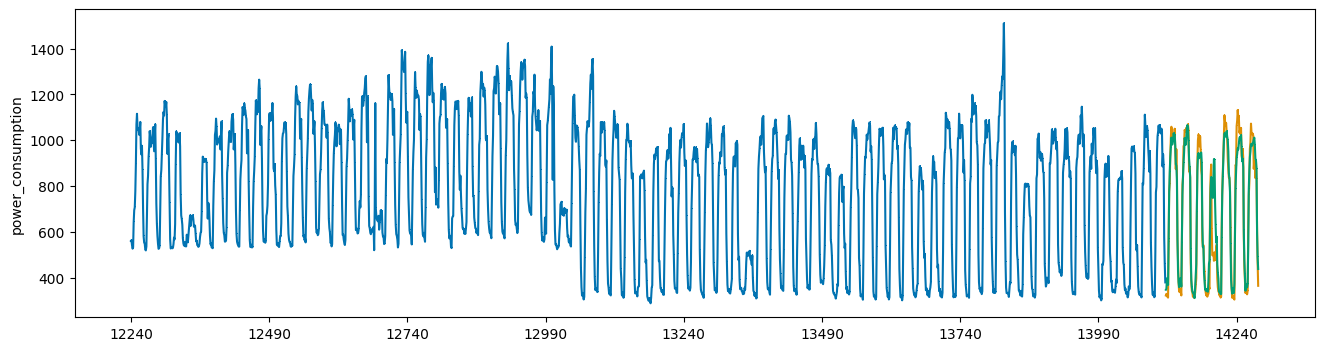

In [50]:
## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

In [33]:
xgb_reg = XGBRegressor(n_estimators = 10000, eta = xgb_params.iloc[47,1], min_child_weight = xgb_params.iloc[47,2], 
                       max_depth = xgb_params.iloc[47,3], colsample_bytree = xgb_params.iloc[47,4], 
                       subsample = xgb_params.iloc[47,5], seed=0)

xgb_reg.set_params(**{'objective':weighted_mse(10)})

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

C:\Users\ARIZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None,
             objective=<function weighted_mse.<locals>.weighted_mse_fixed at 0x000001DD961E53A0>, ...)

## tunning

In [20]:
from sklearn.metrics import make_scorer
smape = make_scorer(SMAPE, greater_is_better = False)

In [ ]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
df = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
preds = np.array([])

grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 5, 1), 
        'max_depth' : np.arange(1,10,2) , 'colsample_bytree' :np.arange(0.5, 1.0, 0.1), 
        'subsample' :np.arange(0.5, 1.0, 0.1)} # fix the n_estimators & eta(learning rate)
        
for i in tqdm(np.arange(1, 101)):
    y = train.loc[train.building_number== i, 'power_consumption']
    x = train.loc[train.building_number == i, ].drop(['power_consumption','building_number'], axis = 1)
    # y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)
    
    
    pds = PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168)))
    gcv = GridSearchCV(estimator = XGBRegressor(seed = 0, gpu_id = 1, 
                                                tree_method = 'gpu_hist', predictor= 'gpu_predictor'),
                       param_grid = grid, scoring = smape, cv = pds, refit = True, verbose = True)
    
    
    gcv.fit(x, y)
    best = gcv.best_estimator_
    params = gcv.best_params_
    print(params)
    pred = best.predict(x_test)
    building = 'building'+str(i)
    print(building + '|| SMAPE : {}'.format(SMAPE(y_test, pred)))
    preds = np.append(preds, pred)
    df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)
    df.to_csv('./hyperparameter_xgb.csv', index = False) # save the tuned parameters

In [ ]:
xgb_reg = XGBRegressor(n_estimators = 10000, eta = xgb_params.iloc[47,1], min_child_weight = xgb_params.iloc[47,2], 
                       max_depth = xgb_params.iloc[47,3], colsample_bytree = xgb_params.iloc[47,4], 
                       subsample = xgb_params.iloc[47,5], seed=0)

xgb_reg.set_params(**{'objective':weighted_mse(100)})

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

## model tunning

In [32]:
xgb_params

,n_estimators,eta,min_child_weight,max_depth,colsample_bytree,subsample
0,100,0.01,4,5,0.8,0.8
1,100,0.01,6,3,0.8,0.9
2,100,0.01,6,7,0.9,0.9
3,100,0.01,3,7,0.8,0.9
4,100,0.01,2,6,0.9,0.9
...,...,...,...,...,...,...
82,100,0.01,6,4,0.8,0.9
83,100,0.01,2,4,0.8,0.8
84,100,0.01,2,4,0.8,0.9
85,100,0.01,4,6,0.8,0.9


In [16]:
xgb_params = pd.read_csv('./hyperparameter_xgb.csv')

In [ ]:
scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list
for i in tqdm(range(100)):
    y = train.loc[train.building_number== i+1, 'power_consumption']
    x = train.loc[train.building_number == i+1, ].drop(['power_consumption','building_number'], axis = 1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)
    
    xgb_reg = XGBRegressor(n_estimators = 10000, eta = 0.03, min_child_weight = 3, 
                       max_depth = 8, colsample_bytree = 0.9, 
                       subsample = 0.7, seed=0)
    xgb_reg.set_params(**{'objective':weighted_mse(100)}) # alpha = 100으로 고정
    
    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), 
                                            (x_valid, y_valid)], early_stopping_rounds=300, verbose=False)
    y_pred = xgb_reg.predict(x_valid)
    pred = pd.Series(y_pred)   
    
    sm = SMAPE(y_valid, y_pred)
    scores.append(sm)
    best_it.append(xgb_reg.best_iteration) ## 실제 best iteration은 이 값에 +1 해주어야 함.

# test inference

In [52]:
test['date_time'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')

# date time feature 생성
test['hour'] = test['date_time'].dt.hour
test['day'] = test['date_time'].dt.weekday
test['month'] = test['date_time'].dt.month
#train['week'] = train['date_time'].dt.weekofyear

# 공휴일 변수 추가 
test['holiday'] = test['day'] .apply(lambda x : 0 if x<5 else 1)


# hour
test['sin_time'] = np.sin(2*np.pi*test.hour/24)
test['cos_time'] = np.cos(2*np.pi*test.hour/24)


def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101):
    temp = test[test['building_number'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

test['solar_power_capacity'] = test['solar_power_capacity'].apply(lambda x : 0 if x=='-' else float(x))
test['ess_capacity'] = test['ess_capacity'].apply(lambda x : 0 if x=='-' else float(x))
test['pcs_capacity'] = test['pcs_capacity'].apply(lambda x : 0 if x=='-' else float(x))
test['building_type'] = test['building_type'].apply(lambda x :int(x))



test = test.fillna(0)

test.drop(['date_time','hour'],axis = 1,inplace = True)


In [26]:
len(best_it)

100

In [41]:
#xgb_params['best_it'] = best_it + best_it[:2]

In [53]:
preds = np.array([]) 
for i in tqdm(range(100)):
    
    pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame
    
    for seed in [0,1,2,3,4,5]: # 각 시드별 예측
        y_train = train.loc[train.building_number== i+1, 'power_consumption']
        x_train = train.loc[train.building_number == i+1, ].drop(['power_consumption','building_number'], axis = 1)
        x_test = test.loc[test.building_number == i+1, ].drop(['building_number'], axis = 1)
        x_test = x_test[x_train.columns]
        
        xgb = XGBRegressor(n_estimators = best_it[i], eta = 0.03, min_child_weight = 3, 
                       max_depth = 8, colsample_bytree = 0.9, 
                       subsample = 0.7, seed=seed)
    
        
        xgb.fit(x_train, y_train)
        y_pred = xgb.predict(x_test)

        # 후처리
        # min_consumption = np.min(y_train[-168:])
        # y_pred = [consumption if consumption > min_consumption else min_consumption for consumption in y_pred ]
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기
        
    pred = pred_df.mean(axis=1)        # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
    preds = np.append(preds, pred)   

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:54<00:00,  2.35s/it]


In [55]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['answer'] = preds

In [56]:
submission.to_csv('./xgb_fix_cooling_rat.csv', index = False)

# post processing
- 예측 주로부터 직전 4주(train set 마지막 28일)의 건물별 요일별 시간대별 전력소비량의 최솟값을 구한 뒤,
- test set의 같은 건물 요일 시간대의 예측값과 비교하여 만약 1번의 최솟값보다 예측값이 작다면 최솟값으로 예측값을 대.

In [93]:
train_to_post = pd.read_csv('./data/train.csv')
train_to_post= train_to_post.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
# 직전 4주
train_to_post = train_to_post[train_to_post.date_time>='20220727 00']
date = pd.to_datetime(train_to_post.date_time)

In [94]:
train_to_post['hour'] = date.dt.hour
train_to_post['day'] = date.dt.weekday
train_to_post['month'] = date.dt.month



In [95]:
pred_clip = []
test_to_post = pd.read_csv('./data/test.csv')

In [96]:
test_to_post = test_to_post.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
date = pd.to_datetime(test_to_post.date_time)
test_to_post['hour'] = date.dt.hour
test_to_post['day'] = date.dt.weekday
test_to_post['month'] = date.dt.month

In [97]:
df = pd.read_csv('./submission_xgb_fix.csv')

In [98]:
for i in range(100):
    min_data = train_to_post.loc[train_to_post.building_number == i+1, ].iloc[-28*24:, :] ## 건물별로 직전 28일의 데이터 불러오기
    ## 요일별, 시간대별 최솟값 계산
    
    pred = df.answer[168*i:168*(i+1)].reset_index(drop=True)
    day =  test_to_post.day[168*i:168*(i+1)].reset_index(drop=True) ## 예측값 요일 불러오기
    hour = test_to_post.hour[168*i:168*(i+1)].reset_index(drop=True) ## 예측값 시간 불러오기
    df_pred = pd.concat([pred, day, hour], axis = 1)
    df_pred.columns = ['pred', 'day', 'hour']
    for j in range(len(df_pred)):
        min_power = min_data.loc[(min_data.day == df_pred.day[j])&(min_data.hour == df_pred.hour[j]), 'power_consumption'].values[0]
        if df_pred.pred[j] < min_power:
            pred_clip.append((min_power + df_pred.pred[j])/2)
        else:
            pred_clip.append(df_pred.pred[j])

In [ ]:
pred_origin = df.answer
pred_clip = pd.Series(pred_clip)

for i in range(100):
    power = train_to_post.loc[train_to_post.building_number == i+1, 'power_consumption'].reset_index(drop=True)
    preds = pred_clip[i*168:(i+1)*168]
    preds_origin = pred_origin[i*168:(i+1)*168]
    preds.index = range(power.index[-1], power.index[-1]+168)
    preds_origin.index = range(power.index[-1], power.index[-1]+168)
    
    plot_series(power, preds,  preds_origin, markers = [',', ',', ','])

In [100]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['answer'] = pred_clip
submission.to_csv('./submission_xgb_fix_post_div.csv', index = False)